In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import gym
from collections import deque
import torch.nn.functional as F
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [6]:
# Define the Q-Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims = (32,32), activation =nn.ReLU):
        super(DQN,self).__init__()

        self.input_layer = nn.Linear(input_dim,hidden_dims[0])

        self.hidden_layer = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layer.append(nn.Linear(hidden_dims[i],hidden_dims[i+1]))
            self.hidden_layer.append(activation())

        self.hidden_layer = nn.Sequential(*self.hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        x= state
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x= self.output_layer(x)
        return x

In [7]:
# Define DQN Agent with Experience Replay Buffer
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr, gamma, epsilon, epsilon_decay, buffer_size):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=buffer_size)
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.eval = False
        
    def act(self, state):
        if np.random.rand() <= self.epsilon and not self.eval:
            if self.epsilon>0.3:
                if state[1]< - 0.001:
                    return 0
                elif state[1]>0.001:
                    return 2
                else:
                    return 1
            else:
                return np.random.choice(self.action_dim)
        q_values = self.model(torch.tensor(state, dtype=torch.float32))
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(torch.tensor(next_state, dtype=torch.float32))).item()
            target_f = self.model(torch.tensor(state, dtype=torch.float32)).detach().numpy()
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(torch.tensor(target_f), self.model(torch.tensor(state, dtype=torch.float32)))
            loss.backward()
            self.optimizer.step()
        if self.epsilon > 0.01:
            self.epsilon *= self.epsilon_decay

In [ ]:
# Initialize environment and agent with Experience Replay Buffer
env = gym.make('MountainCar-v0',render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.9995, buffer_size=10000)

# Train the DQN agent with Experience Replay Buffer
batch_size = 100
num_episodes = 1000
rewards = []
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay(batch_size)

    rewards.append(total_reward)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

c:\Users\Home\anaconda3\envs\ai_pytorch\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Home\anaconda3\envs\ai_pytorch\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Home\anaconda3\envs\ai_pytorch\lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1, Total Reward: -174.0
Episode: 2, Total Reward: -120.0
Episode: 3, Total Reward: -124.0
Episode: 4, Total Reward: -121.0
Episode: 5, Total Reward: -158.0
Episode: 6, Total Reward: -151.0
Episode: 7, Total Reward: -164.0
Episode: 8, Total Reward: -126.0
Episode: 9, Total Reward: -154.0
Episode: 10, Total Reward: -129.0
Episode: 11, Total Reward: -125.0
Episode: 12, Total Reward: -194.0
Episode: 13, Total Reward: -200.0
Episode: 14, Total Reward: -196.0
Episode: 15, Total Reward: -174.0
Episode: 16, Total Reward: -153.0
Episode: 17, Total Reward: -200.0
Episode: 18, Total Reward: -200.0
Episode: 19, Total Reward: -200.0
Episode: 20, Total Reward: -168.0
Episode: 21, Total Reward: -200.0
Episode: 22, Total Reward: -200.0
Episode: 23, Total Reward: -200.0
Episode: 24, Total Reward: -188.0
Episode: 25, Total Reward: -200.0
Episode: 26, Total Reward: -200.0
Episode: 27, Total Reward: -178.0
Episode: 28, Total Reward: -200.0
Episode: 29, Total Reward: -200.0
Episode: 30, Total Rewa

Text(0, 0.5, 'Rewards')

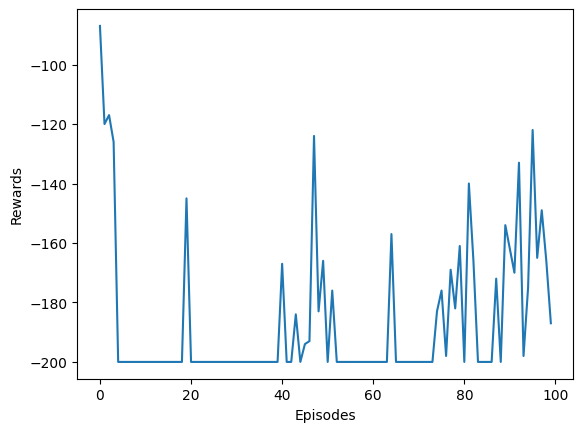

In [9]:
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Rewards")

In [11]:
import cv2

def create_video(source, fps=60, output_name='output'):
    out = cv2.VideoWriter(output_name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (source[0].shape[1], source[0].shape[0]))
    for i in range(len(source)):
        out.write(source[i])
    out.release()

In [12]:
import gym
import numpy as np
from gym.wrappers import RecordVideo

agent.eval= True
# Wrap the environment for recording
# env = RecordVideo(env, video_folder="videos", episode_trigger=lambda e: True)
frames = []
history = []
# Evaluate the trained agent and record video
total_rewards = []
num_episodes_eval = 1
for episode in range(num_episodes_eval):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        env.render()  # Ensure rendering is active
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        frames.append(env.render(mode="rgb_array"))
        history.append({'state':state,'action':action})
    total_rewards.append(total_reward)

env.close()
print(f"Average Total Reward (Evaluation): {np.mean(total_rewards)}")




c:\Users\Home\anaconda3\envs\ai_pytorch\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Average Total Reward (Evaluation): -117.0


,state,action
0,"[-0.54102874, 0.0011391966]",2
1,"[-0.5387589, 0.0022698615]",2
2,"[-0.53537536, 0.003383523]",2
3,"[-0.5309035, 0.0044718287]",2
4,"[-0.5253769, 0.00552661]",2
...,...,...
112,"[0.35432458, 0.040983513]",2
113,"[0.3950924, 0.040767822]",2
114,"[0.43592012, 0.04082772]",2
115,"[0.4770978, 0.04117769]",2


In [13]:
create_video(np.array(frames).reshape(-1,400,600,3), 60, 'output')


In [14]:
import pandas as pd
history=pd.DataFrame(history)

In [18]:
history.to_csv("data.csv")

In [19]:
pd.read_csv('data.csv')

,Unnamed: 0,state,action
0,0,[-0.54102874 0.0011392 ],2
1,1,[-0.5387589 0.00226986],2
2,2,[-0.53537536 0.00338352],2
3,3,[-0.5309035 0.00447183],2
4,4,[-0.5253769 0.00552661],2
...,...,...,...
112,112,[0.35432458 0.04098351],2
113,113,[0.3950924 0.04076782],2
114,114,[0.43592012 0.04082772],2
115,115,[0.4770978 0.04117769],2


In [ ]:
torch.save(agent.model, 'model.pth')